<img src="Images/godzilla.jpg" style="float: left; margin: 20px; height: 140px">

## ゴジラ (Godzilla) Translations 

#### A Japanese to English Machine Learning Project utilising recurrent neural networks, word embeddings and attention layer

_Author: Alfred Zou_

---

## Introduction
---
I'm a big fan of Japan: I've been there twice, tried learning Japanese (with limited success) and own at least 80 Manga (or Japanese comics).

Learning Japanese has subsequently led to my interest in natural language processing.

For my first foray into neural networks, I wanted to see how far I could get with neural machine translation from Japanese to English in two weeks.

### Main Source
---
Most of my code is based off and is a reworking of <a href="https://github.com/thushv89/attention_keras">Thushan's code.</a> I did not modify his attention layer however.

### Other Sources that Helped
---
<a href="https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/">Jason Brownlee's basic neural machine tranlation model</a>

<a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Tensorflow's neural machine translation with attention tutorial.</a>

<a href="https://www.coursera.org/learn/nlp-sequence-models">Andrew Ng's course on sequence to sequence models</a>

### Attributions
---

All Japanese and English sentence pairs from <a href="https://tatoeba.org/eng/downloads">Tatoeba.org</a>. Their data is licensed under the <a href="https://creativecommons.org/licenses/by/2.0/fr/deed.en_GB">Creative Commons - Attribution 2.0 France license.</a>

<a href="https://www.vecteezy.com/free-vector/free-godzilla-icons">Godzilla logo</a>

## Data Preparation
---

### Import Packages & Load Data
---

* `numpy` for arrays and `pandas` for DataFrames
* `pickle` for storing and loading data
* `Mecab` for splitting up Japanese sentences into tokens
* Keras's `Tokenizer`, `pad_sequences` and `to_categorical` to generate sequences for machine learning
* `Tensorflow` and `keras` for creating and running the neural network
* `matplotlib.pyplot` for plotting

In [1]:
import pandas as pd
import numpy as np
import pickle
import MeCab
from pprint import pprint
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import re
import time

Using TensorFlow backend.


In [2]:
def load_data(test_number=12200, train_perc=0.8, valid_perc = 0.2,verbose = 0):
    '''
    Loads the Japanese and English sentence pairs from a pickle file into a pandas' DataFrame.
    Shuffles the rows and creates Japanese and English pairs of training, validation and test data.
    
    First separates out the test set. Then distributes the remainder rows across train set and validation set per train_perc and valid_perc. 
    
    Input: Japanese and English sentence pairs pickle file. [int] test_number, [float] train_percentage and [float] validation_percentage
    Output: Japanese and English pairs of training, validation and test data
    '''
    with open('Data/sentences.pickle','rb') as f:
        sentences = pickle.load(f)
    np.random.seed(42)
    sentences = shuffle(sentences)
    
    # preparing for training, validation and test split
    total_length = len(sentences['text_jpn'])
    train_valid_length = total_length - test_number
    train_number = int(train_valid_length * train_perc)
    valid_number = int(train_valid_length * valid_perc)
    
    # training, validation and test split
    jpn_train = sentences['text_jpn'][:train_number]
    jpn_train = list(jpn_train)
    eng_train = sentences['text_eng'][:train_number]
    eng_train = list(eng_train)
    jpn_valid = sentences['text_jpn'][train_number:train_number+valid_number]
    jpn_valid = list(jpn_valid)
    eng_valid = sentences['text_eng'][train_number:train_number+valid_number]   
    eng_valid = list(eng_valid)
    jpn_test = sentences['text_jpn'][train_number+valid_number:]
    jpn_test = list(jpn_test)
    eng_test = sentences['text_eng'][train_number+valid_number:]
    eng_test = list(eng_test)
    
    if verbose == 1:
        print('Dataset Summary')
        print('--------------------------------------------')
        print('No. of Japanese and English pairs: {}'.format(sentences.shape[0]))
        print('No. Japanese training sentences:   {}'.format(jpn_train.shape[0]))
        print('No. English training sentences:    {}'.format(eng_train.shape[0]))
        print('No. Japanese validation sentences: {}'.format(jpn_validation.shape[0]))
        print('No. English validation sentences:  {}'.format(eng_validation.shape[0]))
        print('No. Japanese test sentences:       {}'.format(jpn_test.shape[0]))
        print('No. English test sentences:        {}'.format(eng_test.shape[0]))
        print('')
        print('Parallel Corpus')
        print('--------------------------------------------')
    
        pprint(sentences.head(5))
    
    return jpn_train, eng_train, jpn_valid, eng_valid, jpn_test, eng_test

In [3]:
# jpn_train, eng_train, jpn_valid, eng_valid, jpn_test, eng_test = load_data()

## Preprocess sentences
---
Remove unecessary punctuations and break down into smaller portions, called tokens

In [4]:
def jpn_preprocess(jpn_input,verbose=0):
    '''
    Prepares Japanese sentences (sentence or list of sentences) by splitting into smaller elements with Mecab for machine learning.
    Multi sentence [strings] are broken down into a list of sentences.
    Inserts <start> and <end> token to help training.
        
    Input: Japanese sentence [string] or [list] of Japanese sentences 
    Output: Each Japanese sentence is broken down into smaller elements. A [list] of [strings] per sentence.
    '''
    jpn_sents = jpn_input
    
    # For sentences
    # Multi length sentences are broken down into a list of sentences
    if type(jpn_input)==str:
        sent = re.sub(r'[" "]+', "", jpn_input)
        sent = re.sub(r'([\?。？])',r'\1 ',sent)
        sent = re.sub(r'[" "]+', " ", sent)
        sent = sent.strip()
        sent = re.split(r' ',sent)
        jpn_sents = sent
           
    # For list of sentences
    jpn_pp = []
    for jpn_sent in jpn_sents:
        jpn_pp.append(MeCab.Tagger("-Owakati").parse(jpn_sent).split())
    for jpn_sent in jpn_pp:
        jpn_sent.append('<end>')
        jpn_sent.insert(0,'<start>')
    if verbose ==1:
        pprint(jpn_pp[:2])
    return jpn_pp

In [5]:
def eng_preprocess(eng_input,verbose=0):
    '''
    Prepares English sentences (sentence or list of sentences) by splitting on white spaces for machine learning.
    Lowers each setences and filters out punctuation that is not '.' or '?'.
    Inserts <start> and <end> token to help training.
        
    Input: English sentence [string] or [list] of English sentences 
    Output: Each English sentence is broken down into smaller elements. A [list] of [strings] per sentence.
    '''
    eng_sents = eng_input
    
    # For sentences
    if type(eng_input)==str:
        eng_sents = [eng_input]
    
    # For list of sentences
    eng_pp = []
    for eng_sent in eng_sents:
        eng_sent = eng_sent.lower()
        eng_sent = re.sub(r"[^A-Za-z0-9_ .?]", r"", eng_sent)
        eng_sent = re.sub(r"([?.])", r" \1 ", eng_sent)
        eng_sent = re.sub(r'[" "]+', " ", eng_sent)
        eng_pp.append(eng_sent.split())
    for eng_sent in eng_pp:
        eng_sent.append('<end>')
        eng_sent.insert(0,'<start>')
    if verbose ==1:
        pprint(eng_pp[:2])
    return eng_pp

### Generating train, validate and test sets
---
Splits the loaded data into train, validate and test sets

In [7]:
def generate_tvt_data():
    '''
    Loads and splits all the data into train, test and split for Japanese and English sentences using load_data function
    Preprocesses all the sentences using jpn_preprocess and eng_preprocess function
    Saves all these preprocessed sentences into pickle files
    '''   
    jpn_train, eng_train, jpn_valid, eng_valid, jpn_test, eng_test = load_data(test_number=12200, train_perc=0.8, valid_perc = 0.2)
    
    jpn_pp_train,jpn_pp_valid,jpn_pp_test = jpn_preprocess(jpn_train),jpn_preprocess(jpn_valid),jpn_preprocess(jpn_test)
    eng_pp_train,eng_pp_valid,eng_pp_test = eng_preprocess(eng_train),eng_preprocess(eng_valid),eng_preprocess(eng_test)

    with open('Generated Data/tvt/jpn_pp_train.pickle', 'wb') as f:
        pickle.dump(jpn_pp_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Generated Data/tvt/jpn_pp_valid.pickle', 'wb') as f:
        pickle.dump(jpn_pp_valid, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Generated Data/tvt/jpn_pp_test.pickle', 'wb') as f:
        pickle.dump(jpn_pp_test, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('Generated Data/tvt/eng_pp_train.pickle', 'wb') as f:
        pickle.dump(eng_pp_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Generated Data/tvt/eng_pp_valid.pickle', 'wb') as f:
        pickle.dump(eng_pp_valid, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Generated Data/tvt/eng_pp_test.pickle', 'wb') as f:
        pickle.dump(eng_pp_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# generate_tvt_data()

In [9]:
def load_tvt_data():
    '''
    Loads all preprocessed Japanese and English sentences
    '''   
    with open('Generated Data/tvt/jpn_pp_train.pickle', 'rb') as f:
        jpn_pp_train=pickle.load(f)
    with open('Generated Data/tvt/jpn_pp_valid.pickle', 'rb') as f:
        jpn_pp_valid=pickle.load(f)
    with open('Generated Data/tvt/jpn_pp_test.pickle', 'rb') as f:
        jpn_pp_test=pickle.load(f)
        
    with open('Generated Data/tvt/eng_pp_train.pickle', 'rb') as f:
        eng_pp_train=pickle.load(f)
    with open('Generated Data/tvt/eng_pp_valid.pickle', 'rb') as f:
        eng_pp_valid=pickle.load(f)
    with open('Generated Data/tvt/eng_pp_test.pickle', 'rb') as f:
        eng_pp_test=pickle.load(f)
    return jpn_pp_train,jpn_pp_valid,jpn_pp_test,eng_pp_train,eng_pp_valid,eng_pp_test

In [10]:
# jpn_pp_train,jpn_pp_valid,jpn_pp_test,eng_pp_train,eng_pp_valid,eng_pp_test = load_tvt_data()

### Generating tokenizers
---
Creates Japanese and English tokens that hold a dictionary of every encountered word in the train set

In [11]:
def tokenizer(pp_train,verbose=0):
    '''
    Create a Keras Tokenizer based on preprocessed Japanese or English sentences.
    This takes every unique token and maps it to an index, this can be retrieved using tokenizer.word_index returning as a dictionary {unique_token:index}
    Create the token <UNK> for tokens that don't appear in the training data

    Input: [List] of preprocessed Japanese or English sentences
    Output: [Tokenizer] model used for creating a sequence
    '''
    
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(pp_train)
     
    if verbose ==1:
        print([{k:v} for k,v in tokenizer.word_index.items() if v<20])
    
    return tokenizer

In [12]:
def generate_tokenizers(jpn_pp_train,eng_pp_train):
    '''
    Loads and splits all the data into train, test and split for Japanese and English sentences using load_data function
    Preprocesses all the sentences using jpn_preprocess and eng_preprocess function
    Saves all these preprocessed sentences into pickle files
    '''       
    jpn_tokenizer = tokenizer(jpn_pp_train)
    eng_tokenizer = tokenizer(eng_pp_train)
    
    with open('Generated Data/tokenizers/jpn_tokenizer.pickle', 'wb') as f:
        pickle.dump(jpn_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open('Generated Data/tokenizers/eng_tokenizer.pickle', 'wb') as f:
        pickle.dump(eng_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# generate_tokenizers(jpn_pp_train,eng_pp_train)

In [14]:
def load_tokenizers():
    '''
    Loads all tokenizers created from preprocessed Japanese and English sentences
    '''   
    with open('Generated Data/tokenizers/jpn_tokenizer.pickle', 'rb') as f:
        jpn_tokenizer = pickle.load(f)
    with open('Generated Data/tokenizers/eng_tokenizer.pickle', 'rb') as f:
        eng_tokenizer = pickle.load(f)
        
    return jpn_tokenizer, eng_tokenizer

In [15]:
# jpn_tokenizer, eng_tokenizer = load_tokenizers()

### Generating Sequences
---
Replaces the token in each sentence with the respective index in the tokenizer

In [16]:
def sequence(tokenizer,max_tok_length,pp_sent,verbose=0,head=5):
    '''
    Replaces tokens in preprocessed sentences using the dictionary tokenizer.word_index.
    Missing words are mapped to index 1 to represent <UNK>.
    Sentences that are too short are post padded with the index 0 to match the training set's maximum token length
    
    Input: Japanese or English [Tokenizer], preprocessed Japanese or English maximum token length
    Output: Japanese or English sequence [Array]
    '''
    sequence = tokenizer.texts_to_sequences(pp_sent)
    sequence = pad_sequences(sequence, maxlen=max_tok_length, padding='post')
    
    if verbose == 1:
        for n in range(head):
            reversed = []
            for i in sequence[n]:
                if i != 0:
                    reversed.append(tokenizer.index_word[i])
                else:
                    reversed.append(0)
            print("Original              : ",pp_sent[n])        
            print("Reversed from sequence: ",reversed)
    
    return sequence

## Model Creation
---

### Defining Neural Network Structure
---
Here is a summary of the model:

Notes:
1. Tanh as the activation function for hidden layers
2. Buchanan's attention model
3. Optimizer: adam
4. Loss function: categorical_crossentropy

Encoder
1. The Japanese sequence is passed into encoder_embedding layer and turned into word embeddings
2. These word embeddings are fed into the encoder_GRU, one token at a time
3. The encoder_GRU outputs it output to the attention layer, and its state to initialise the decoder_GRU

Decoder
1. The <start> token is first passed into the decoder_embedding layer and turned into a word embedding, which is passed into the decoder_GRU layer
2. The decoder_GRU output is then fed into the attention layer with encoder_GRU outputs, to obtain attention layer outputs
3. Attention layer outputs and decoder_GRU outputs are combined together in the concat_layer
4. The concat_layer outputs are fed into time distributed dense layers, and softmaxed to predict the next word
5. The next word becomes the new input of the decoder_embedding layer isntead of <start> token, repeat steps 1-4 until reaching the maximum english token length in the training set

<img src="Images/full_model_plot.jpg">

In [17]:
class AttentionLayer(Layer):
    """
    Attention layer code taken from here: https://github.com/thushv89/attention_keras
    
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            jpn_seq_len, jpn_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*jpn_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, jpn_hidden))
            # <= batch_size*jpn_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, jpn_seq_len, jpn_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*jpn_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, jpn_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, jpn_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, jpn_seq_len))
            # <= batch_size, jpn_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, jpn_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [23]:
def define_nmt(hidden_size, jpn_timesteps, jpn_vocab_size, eng_timesteps, eng_vocab_size):
    """ 
    Creates a Tensorflow model. 
    The general idea is that the Japanese sequence is passed through the encoder to produce a context vector.
    The context vector containing all the ideas of the Japanese seqeunce is passed through a decoder to translate it into an English sequence.
    The attention layer provides the decoder with weights, on which part of the input Japanese sequence should the respective
    English sequence look at to produce its translations.   

    Inputs: [int] hidden_size or number of nodes in the GRUs, [int] batch_size or the number of Japanese sequences fed into the model during the training step
            [int] jpn_timesteps or maxium Japanese token length in the preprocessed training data, this corresponds to the number of GRU timesteps
            [int] jpn_vocab_size or how many unique tokens in the preprocessed training data
            [int] eng_timesteps or maxium English token length in the preprocessed training data, this corresponds to the number of GRU timesteps
            [int] eng_vocab_size or how many unique tokens in the preprocessed training data
    Outputs: 3x [Tensorflow Models]: full_model for training. encoder and decoder model for prediction
    """

    '''
    The full_model is used for training. In combination with the train function, it allows us to use teacher forcing
    '''   
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(jpn_timesteps), name='encoder_inputs')
    decoder_inputs = Input(shape=(eng_timesteps - 1), name='decoder_inputs')
    
    # Encoder Embedding
    jpn_embedding = Embedding(jpn_vocab_size, 300,input_length=jpn_timesteps, name = 'encoder_embedding')
    encoder_embeddings=jpn_embedding(encoder_inputs)
    
    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_embeddings)

    # Decoder Embedding
    eng_embedding = Embedding(eng_vocab_size, 300,input_length=eng_timesteps, name = 'decoder_embedding')
    decoder_embeddings=eng_embedding(decoder_inputs)    
    
    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_embeddings, initial_state=encoder_state)

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(eng_vocab_size, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy')

    """ 
    The inf_encoder_model and inf_decoder_models are used during inference (or prediction).
    Note the GRU and attention layers are reused from the full_model and hence share weights
    
    For the encoder model: the Japanese sequence is passed into an embedding layer which is passed into the GRU.
    This outputs the GRUs output and its final hidden state.
    """
    # Input layer
    encoder_inf_inputs = Input(shape=(jpn_timesteps), name='encoder_inf_inputs')
    
    # Embedding and GRU layers
    encoder_inf_embeddings=jpn_embedding(encoder_inf_inputs)
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_embeddings)
    
    # Encoder model
    inf_encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    # Instantiating decoder input layer. This will intially be the <start> token, followed by future English word predictions 
    # Instantiating the initial decoder state. This will intially be the encoder_inf_state, followed by future decoder_inf_states
    decoder_inf_inputs = Input(shape=(1), name='decoder_word_inputs')
    decoder_init_state = Input(shape=(hidden_size), name='decoder_init')
    
    # The English word is fed through the embedding layer and GRU layers
    decoder_inf_embeddings=eng_embedding(decoder_inf_inputs)
    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_embeddings, initial_state=decoder_init_state)
    
    # encoder_inf_out is the encoder_inf_out from the encoder_model
    encoder_inf_out = Input(shape=(jpn_timesteps, hidden_size), name='encoder_inf_out')
    
    # Encoder_inf_out from encoder_model and decoder_inf_out from decoder_GRU is passed through attention layer and time distributed dense layers
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_out, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    
    # Decoder Model
    inf_decoder_model = Model(inputs=[encoder_inf_out, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

    return full_model, inf_encoder_model, inf_decoder_model

### Defining Training
---
Trains on specified batches of sequence pairs using batch gradient descent, teacher forcing and back propogation.

For each training batch, check the validation batch losses.

In [24]:
def train(full_model, jpn_seq_train, eng_seq_train,jpn_seq_valid, eng_seq_valid, batch_size=128, n_epochs=10):
    """ 
    Training full_model on batches of training Japanese and English sequence pairs
    Uses batch gradient descent and back propogation to update weights in the model
    
    Comparison with validation set to check overfitting and ability to generalize
    """
    
    # Total train and validation loss for plotting losses
    total_train_loss =[]
    total_valid_loss = []
    
    for epoch in range(n_epochs):
        
        print('Epoch {} --------------------'.format(epoch+1))
        
        # Epoch train and validation losses for printing, and start Epoch timing
        epoch_train_loss = []
        epoch_valid_loss = []
        epoch_start = time.time()
        batch = 0
        
        for bi in range(0, jpn_seq_train.shape[0] - batch_size, batch_size):
            
            '''
            Slice the jpn_seq_train and eng_seq_train to match batch_size
            
            Onehot encode the english sequence so we can do training
            We're offsetting the input eng_onehot_seq's eng_timesteps by 1 to enable teacher forcing, to increase train speed
            
            Batch gradient descent and back propogation to update weights in the model
            '''
            
            eng_oh_train_seq = to_categorical(eng_seq_train[bi:bi + batch_size, :], num_classes=eng_vocab_size)
            full_model.train_on_batch([jpn_seq_train[bi:bi + batch_size,:], eng_seq_train[bi:bi + batch_size, :-1]], eng_oh_train_seq[:, 1:, :])
            
            # Evaluate losses and append to epoch and total train loss
                        
            train_batch_loss = full_model.evaluate([jpn_seq_train[bi:bi + batch_size,:], eng_seq_train[bi:bi + batch_size, :-1]], eng_oh_train_seq[:, 1:, :],verbose=0,)
            epoch_train_loss.append(train_batch_loss)
            total_train_loss.append(train_batch_loss)
            
            '''
            To ensure we can later on plot the train vs validation loss, we validate on batches of data in the ratio of train_valid_ratio.
            As we take the floor division, we will always arrive at the same amount of recorded losses for train and validation
            '''
            train_valid_ratio = len(jpn_seq_train)/len(jpn_seq_valid)
            bv = int(bi//train_valid_ratio)
            valid_batch_size = int(batch_size//train_valid_ratio)
            
            eng_oh_valid_seq = to_categorical(eng_seq_valid[bv:bv + valid_batch_size, :], num_classes=eng_vocab_size)

            valid_batch_loss = full_model.evaluate([jpn_seq_valid[bv:bv + valid_batch_size,:], eng_seq_valid[bv:bv + valid_batch_size, :-1]], eng_oh_valid_seq[:, 1:, :],verbose=0)
            epoch_valid_loss.append(valid_batch_loss)
            total_valid_loss.append(valid_batch_loss)
                
            if batch == 0:
                batch_start = time.time()
                print('Epoch {} Batch {} Train loss {:.4f} Valid loss {:.4f}'.format(epoch + 1, batch +1, train_batch_loss,valid_batch_loss))    
            elif batch % 100 == 0:
                batch_end = time.time()
                batch_time = batch_end - batch_start
                print('Epoch {} Batch {} Train loss {:.4f} Valid loss {:.4f} Time per 100 batches {:.2f}s'.format(epoch + 1, batch +1, train_batch_loss,valid_batch_loss,batch_time))    
                batch_start = batch_end
            batch += 1
    
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        if (epoch + 1) % 1 == 0:
            print("Epoch {}. Train batch loss {:.4f}. Valid batch loss {:.4f}. Took {:.2f}s".format(epoch + 1, np.mean(epoch_train_loss),np.mean(epoch_valid_loss),epoch_time))

    return total_train_loss, total_valid_loss

In [20]:
def test_loss(full_model, jpn_seq_test, eng_seq_test, test_batch_size=64):
    """ 
    Checks test_loss on test set
    """    
    total_test_loss =[]
    epoch_start = time.time()
    
    batch = 0
    
    for bi in range(0, jpn_seq_test.shape[0] - test_batch_size, test_batch_size):
        eng_oh_test_seq = to_categorical(eng_seq_test[bi:bi + test_batch_size, :], num_classes=eng_vocab_size)

        test_batch_loss = full_model.evaluate([jpn_seq_test[bi:bi + test_batch_size,:], eng_seq_test[bi:bi + test_batch_size, :-1]], eng_oh_test_seq[:, 1:, :],verbose=0)
        total_test_loss.append(test_batch_loss)

        if batch == 0:
            batch_start = time.time()
            print('Batch {} Test loss {:.4f}'.format(batch+1,test_batch_loss))
        elif batch % 20 == 0:
            batch_end = time.time()
            batch_time = batch_end - batch_start
            print('Batch {} Test loss {:.4f} Time per 20 batches {:.2f}s'.format(batch+1,test_batch_loss,batch_time))
            batch_start=batch_end  
        batch +=1 

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    print("Test batch loss {:.4f}. Took {:.2f}s".format(np.mean(total_test_loss),epoch_time))
    
    return total_test_loss

#### Model Training Code
---
Preprocess training, validation and test data into sequences

Create, train and save model

In [21]:
# Load all preprocessed train, validate and test Japanese and English sentences
jpn_pp_train,jpn_pp_valid,jpn_pp_test,eng_pp_train,eng_pp_valid,eng_pp_test = load_tvt_data()

# Load all the Japanese and English Tokenizers
jpn_tokenizer, eng_tokenizer = load_tokenizers()

# Find the maximum vocab size
# A +1 is added for the padding token 0
jpn_vocab_size = len(jpn_tokenizer.word_index) + 1
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# Find the maximum number of tokens in each Japanese and English sequence
# This is equivalent to the number of timesteps in the GRU
jpn_timesteps = max([len(sent) for sent in jpn_pp_train])
eng_timesteps = max([len(sent) for sent in eng_pp_train])

# Creates all the sequences
jpn_seq_train = sequence(jpn_tokenizer,jpn_timesteps,jpn_pp_train)
eng_seq_train = sequence(eng_tokenizer,eng_timesteps,eng_pp_train)
jpn_seq_test = sequence(jpn_tokenizer,jpn_timesteps,jpn_pp_test)
eng_seq_test = sequence(eng_tokenizer,eng_timesteps,eng_pp_test)
jpn_seq_valid = sequence(jpn_tokenizer,jpn_timesteps,jpn_pp_valid)
eng_seq_valid = sequence(eng_tokenizer,eng_timesteps,eng_pp_valid)

In [25]:
# Setting model parameters
test_number,train_perc,valid_perc = 12200,0.8,0.2
iteration = 1
batch_size = 64
epochs = 5
hidden_size = 1024

# Creating the model
full_model,inf_encoder_model,inf_decoder_model = define_nmt(hidden_size = hidden_size, jpn_timesteps=jpn_timesteps, jpn_vocab_size=jpn_vocab_size, 
                                                    eng_timesteps=eng_timesteps, eng_vocab_size=eng_vocab_size)

# # Model summaries
# full_model.summary()
# inf_encoder_model.summary()
# inf_decoder_model.summary()
# tf.keras.utils.plot_model(full_model)
# tf.keras.utils.plot_model(inf_encoder_model)
# tf.keras.utils.plot_model(inf_decoder_model)

# Train model
total_train_loss, total_valid_loss = train(full_model=full_model,jpn_seq_train=jpn_seq_train, eng_seq_train=eng_seq_train,
                                             jpn_seq_valid=jpn_seq_valid, eng_seq_valid=eng_seq_valid, batch_size=batch_size, n_epochs=epochs)

# Set folder path
path = f'te{test_number}_tr{train_perc}_v{valid_perc}_i{iteration}_b{batch_size}_e{epochs}_hs{hidden_size}'

# Try create model folder
try:
    os.mkdir(path)
except:
    pass

# Save train_valid_loss image
pd.DataFrame({'total_train_loss':total_train_loss,'total_valid_loss':total_valid_loss}).plot().\
                get_figure().savefig(f'Generated Data/models/{path}/train_valid_loss.jpg')

# Save model
full_model.save(f'Generated Data/models/{path}/full_model.h5')
inf_encoder_model.save(f'Generated Data/models/{path}/inf_encoder_model.h5')
inf_decoder_model.save(f'Generated Data/models/{path}/inf_decoder_model.h5')

# Check test loss
_ = test_loss(full_model=full_model, jpn_seq_test=jpn_seq_test, eng_seq_test=eng_seq_test, test_batch_size=64)

Epoch 1 --------------------
Epoch 1 Batch 1 Train loss 9.6472 Valid loss 9.6486
Epoch 1 Batch 101 Train loss 2.8985 Valid loss 2.9979 Time per 100 batches 80.05s


KeyboardInterrupt: 

#### Model Loading Code
---
Load model

In [35]:
# Setting model parameters
test_number,train_perc,valid_perc = 12200,0.8,0.2
iteration = 1
batch_size = 64
epochs = 10
hidden_size = 1024

# Setting path
path = f'te{test_number}_tr{train_perc}_v{valid_perc}_i{iteration}_b{batch_size}_e{epochs}'

full_model = load_model(f'Generated Data/models/{path}/full_model.h5',custom_objects={'AttentionLayer':AttentionLayer})
inf_encoder_model = load_model(f'Generated Data/models/{path}/inf_encoder_model.h5',compile=False)
inf_decoder_model = load_model(f'Generated Data/models/{path}/inf_decoder_model.h5',custom_objects={'AttentionLayer':AttentionLayer},compile=False)

In [22]:
# # Setting model parameters
# test_number,train_perc,valid_perc = 12200,0.8,0.2
# iteration = 1
# batch_size = 64
# epochs = 20
# hidden_size = 1024

# # Setting path
# path = f'te{test_number}_tr{train_perc}_v{valid_perc}_i{iteration}_b{batch_size}_e{epochs}_hs{hidden_size}'

# full_model = load_model(f'Generated Data/models/{path}/full_model.h5',custom_objects={'AttentionLayer':AttentionLayer})
# inf_encoder_model = load_model(f'Generated Data/models/{path}/inf_encoder_model.h5',compile=False)
# inf_decoder_model = load_model(f'Generated Data/models/{path}/inf_decoder_model.h5',custom_objects={'AttentionLayer':AttentionLayer},compile=False)

#### Inference Code
---
Using the inf_encoder_model and inf_decoder_model to generate a translation and attention weights

In [38]:
def inf_nmt(inf_encoder_model, inf_decoder_model, test_jpn_seq,eng_timesteps,eng_tokenizer):
    """
    Passes the test_jpn_seq through the inf_encoder_model and inf_decoder_model to create a translation and weights
    
    Input: [Model] inf_encoder_model, [Model] inf_decoder_model, [array]sequence of test sentence, 
            [int] eng_timesteps or maximum english token length, [Tokenizer] eng_tokenizer with dictionary of unique words from train set
    Output: [string] eng_text translation, [array] attention_weights
    """
    
    attention_weights = []
    eng_text = ''

    # Passes the preprocessed Japanese test sequence through the encoder model to receive the encoder_GRU outputs needed for the inf_decoder_model
    enc_outs, enc_last_state = inf_encoder_model.predict(test_jpn_seq)
    
    # The intial state for the encoder_GRU
    dec_state = enc_last_state
    
    # turns the <start> token into a sequence based on eng tokenizer
    test_eng_seq = sequence(eng_tokenizer, 1,['<start>'])    
    
    # For each timestep, generate a new english token
    for i in range(eng_timesteps):
        
        # Takes in the encoder output, as well as the initial decoder state from the encoder_GRU
        # dec_state updates itself
        # test_eng_seq changes, as new english tokens are predicted
        dec_out, attention, dec_state = inf_decoder_model.predict([enc_outs, dec_state, test_eng_seq])
        
        # Locate the largest propbability and find the axis
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]
        if dec_ind == 0:
            break
        test_eng_seq = sequence(eng_tokenizer, 1, [eng_tokenizer.index_word[dec_ind]])

        attention_weights.append((dec_ind, attention))
        eng_text += eng_tokenizer.index_word[dec_ind] + ' '

    return eng_text, attention_weights

In [39]:
def plot_attention_weights(test_jpn_seq, attention_weights):
    """
    Plots the attention weights
    
    Input: [array] sequie,[array] attention_weights from inf_nmt
    Output: matplotlib figure showing attention weights between Japanese tokens and English tokens
    """
    
    # Find first index=0, or padding
    itemindex = np.where(test_jpn_seq.reshape(-1)==0)
    itemindex[0][0]   
    
    # load Japanese compatible matplotlib font
    fpath = 'Font/Osaka.ttc'
    prop = fm.FontProperties(fname=fpath)
    
    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        # Only take the non-padded 
        mats.append(attn.reshape(-1)[:itemindex[0][0]])
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(attention_mat,cmap='Purples')

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([eng_tokenizer.index_word[inp] if inp != 0 else "<Res>" for inp in dec_inputs], fontproperties=prop)
    ax.set_yticklabels([jpn_tokenizer.index_word[inp] if inp != 0 else "<Res>" for inp in test_jpn_seq.ravel()], fontproperties=prop)

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)

### Generate Translation
---

input:                 このバスは海水浴場に行きますか。
correct translation:   does this bus go to the beach?
predicted translation: this bus will go to the beach . . . 


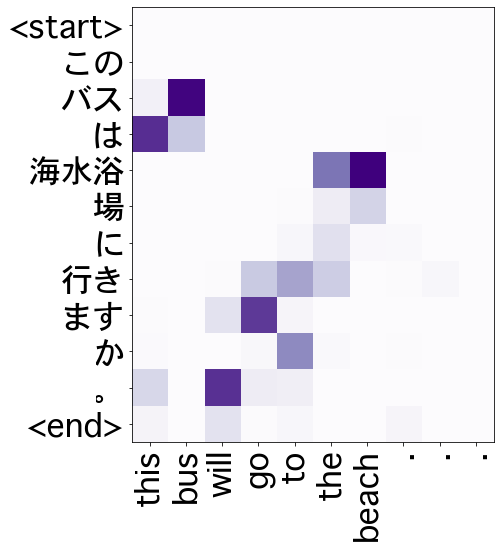

In [42]:
i=0

jpn_train, eng_train, jpn_valid, eng_valid, jpn_test, eng_test = load_data()
test_jpn_seq= jpn_train[i]
test_jpn_seq =jpn_preprocess(test_jpn_seq)
test_jpn_seq = sequence(jpn_tokenizer,jpn_timesteps,test_jpn_seq)
eng_text,attention_weights = inf_nmt(inf_encoder_model=inf_encoder_model,inf_decoder_model=inf_decoder_model,test_jpn_seq = test_jpn_seq, eng_timesteps=eng_timesteps, eng_tokenizer=eng_tokenizer)
plot_attention_weights(test_jpn_seq=test_jpn_seq, attention_weights=attention_weights)
print('input:                ',jpn_train[i])
print('correct translation:  ',eng_train[i])
print('predicted translation:',eng_text)

input:                 彼は父親ほど背が高くない。
correct translation:   he is not as tall as his father.
predicted translation: is not as tall as he is . . . 


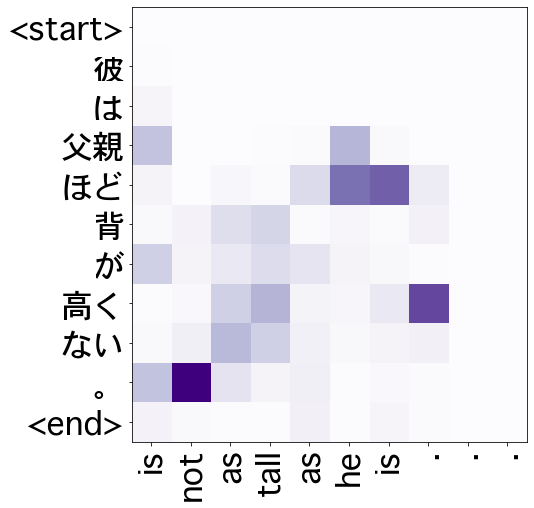

In [40]:
i=1

jpn_train, eng_train, jpn_valid, eng_valid, jpn_test, eng_test = load_data()
test_jpn_seq= jpn_test[i]
test_jpn_seq =jpn_preprocess(test_jpn_seq)
test_jpn_seq = sequence(jpn_tokenizer,jpn_timesteps,test_jpn_seq)
eng_text,attention_weights = inf_nmt(inf_encoder_model=inf_encoder_model,inf_decoder_model=inf_decoder_model,test_jpn_seq = test_jpn_seq, eng_timesteps=eng_timesteps, eng_tokenizer=eng_tokenizer)
plot_attention_weights(test_jpn_seq=test_jpn_seq, attention_weights=attention_weights)
print('input:                ',jpn_test[i])
print('correct translation:  ',eng_test[i])
print('predicted translation:',eng_text)

input:                 トムとメアリーはビーチバレーをしている。
correct translation:   tom and mary are playing beach volleyball.
predicted translation: and mary are talking to tom . . . 


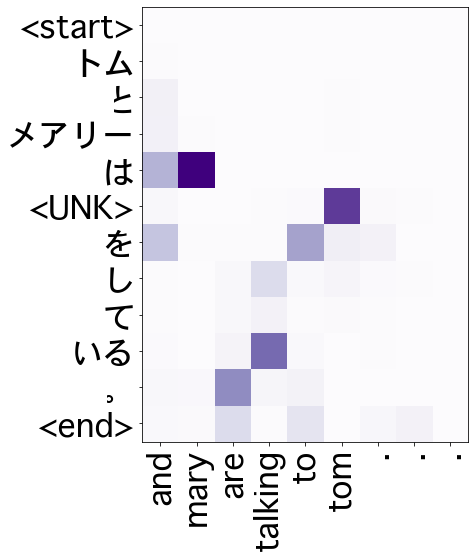

In [41]:
i=14

jpn_train, eng_train, jpn_valid, eng_valid, jpn_test, eng_test = load_data()
test_jpn_seq= jpn_test[i]
test_jpn_seq =jpn_preprocess(test_jpn_seq)
test_jpn_seq = sequence(jpn_tokenizer,jpn_timesteps,test_jpn_seq)
eng_text,attention_weights = inf_nmt(inf_encoder_model=inf_encoder_model,inf_decoder_model=inf_decoder_model,test_jpn_seq = test_jpn_seq, eng_timesteps=eng_timesteps, eng_tokenizer=eng_tokenizer)
plot_attention_weights(test_jpn_seq=test_jpn_seq, attention_weights=attention_weights)
print('input:                ',jpn_test[i])
print('correct translation:  ',eng_test[i])
print('predicted translation:',eng_text)

input:                 ゴジラが目覚める
predicted translation: at the mercy of the state . . . . 


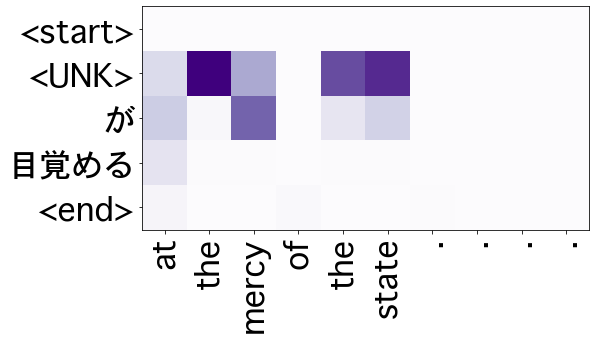

In [43]:
test_jpn_inp= 'ゴジラが目覚める'
test_jpn_seq =jpn_preprocess(test_jpn_inp)
test_jpn_seq = sequence(jpn_tokenizer,jpn_timesteps,test_jpn_seq)
eng_text,attention_weights = inf_nmt(inf_encoder_model=inf_encoder_model,inf_decoder_model=inf_decoder_model,test_jpn_seq = test_jpn_seq, eng_timesteps=eng_timesteps, eng_tokenizer=eng_tokenizer)
plot_attention_weights(test_jpn_seq=test_jpn_seq, attention_weights=attention_weights)
print('input:                ',test_jpn_inp)
print('predicted translation:',eng_text)